In [911]:
import math
import iapws
import numpy
import matplotlib.pyplot as plt
from iapws import IAPWS97 as gas
from math import sqrt
from enum import Enum

In [912]:
def get_ksi(z, x):
    _x = numpy.array([0.6, 0.7, 0.8, 0.9, 1])
    ksi = { 8: numpy.array([0.84, 0.9, 0.94, 0.96, 0.93])}
    print(ksi[z])
    return numpy.interp(x, _x, ksi[z], left=None, right=None, period=None)

In [913]:
MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
cm = 1/100
mm = 1 / 1000
kJ = 1000
to_kelvin = lambda x: x + 273.15 if x else None

In [914]:
electrical_power = 180 * (10 ** 6)
p0 = 24.5 * MPa
t0 = 560
p_middle = 3.46 * MPa
t_middle = 565
pk = 3.7 * kPa
t_feed_water = 268
p_feed_water = 1.4 * p0
z = 8

internal_efficiency = 0.85
mechanical_efficiency = 0.994
generator_efficiency = 0.99

In [915]:
delta_p0 = 0.05 * p0
delta_p_middle = 0.1 * p_middle
delta_p_1 = 0.03 * p_middle

real_p0 = p0 - delta_p0
real_p1t = p_middle + delta_p_middle
real_p_middle = p_middle - delta_p_1

In [916]:
_point_0 = gas(P = p0 * unit, T=to_kelvin(t0))
point_0 = gas(P=real_p0 * unit, h=_point_0.h)
point_1t = gas(P=real_p1t * unit, s=_point_0.s)

hp_heat_drop = (_point_0.h - point_1t.h) * internal_efficiency
h_1 = point_0.h - hp_heat_drop
point_1 = gas(P=real_p1t * unit, h=h_1)

In [917]:
_point_middle = gas(P=p_middle * unit, T=to_kelvin(t_middle))
point_middle = gas(P=real_p_middle * unit, h=_point_middle.h)
point_2t = gas(P=pk * unit, s=_point_middle.s)

lp_heat_drop = (_point_middle.h - point_2t.h) * internal_efficiency
h_2 = point_middle.h - lp_heat_drop
point_2 = gas(P=pk * unit, h=h_2)

efficiency_hp = (_point_0.h - point_1.h) / (_point_0.h - point_1t.h)
efficiency_lp = (_point_middle.h - point_2.h) / (_point_middle.h - point_2t.h)

In [918]:
point_k_water = gas(P=pk * unit, x=0)

point_feed_water = gas(P=p_feed_water * unit, T=to_kelvin(t_feed_water))

In [919]:
numenator_without = point_2.T * (_point_middle.s - point_k_water.s)
denumenator_without = (point_0.h - point_1t.h) + (point_middle.h - point_k_water.h)
without_part = 1 - (numenator_without / denumenator_without)

numenator_infinity = point_2.T * (_point_middle.s - point_feed_water.s)
denumenator_infinity = (point_0.h - point_1t.h) + (point_middle.h - point_feed_water.h)
infinity_part = 1 - (numenator_infinity / denumenator_infinity)

ksi_infinity = 1 - (without_part / infinity_part)

In [920]:
coeff = (point_feed_water.T - point_2.T) / (to_kelvin(374.2) - point_2.T)

In [921]:
ksi = get_ksi(z, coeff) * ksi_infinity

[0.84 0.9  0.94 0.96 0.93]


In [922]:
eff_num = hp_heat_drop + lp_heat_drop
eff_denum = hp_heat_drop + (point_middle.h - point_k_water.h)

efficiency = (eff_num / eff_denum) * (1 / (1 - ksi))

In [923]:
estimated_heat_drop = efficiency * ((point_0.h - point_feed_water.h) + (point_middle.h - point_1.h))

In [924]:
inlet_mass_flow = electrical_power / (estimated_heat_drop * 1000 * mechanical_efficiency * generator_efficiency)

In [925]:
condenser_mass_flow = (
    electrical_power /
    ((point_2.h - point_k_water.h) * 1000 * mechanical_efficiency * generator_efficiency) * ((1 / efficiency) - 1)
)

In [926]:
print("Массовый расход в турбину на входе", inlet_mass_flow)
print("Массовый расход в конденсатор:", condenser_mass_flow)

Массовый расход в турбину на входе 138.84420347528203
Массовый расход в конденсатор: 92.63824511468


In [927]:
#Expansion in turbine process

entropy_step = 0.1
delta = 0.03

pressure_lines_s = {
    "p0" : numpy.arange(_point_0.s*(1 - delta), _point_0.s*(1 + delta), entropy_step),
    "p0_real" : numpy.arange(point_0.s*(1 - delta), point_0.s*(1 + delta), entropy_step),
    "p1" : numpy.arange(point_1t.s*(1 - delta), point_1.s*(1 + delta), entropy_step),
    "p_middle" : numpy.arange(_point_middle.s*(1 - delta), _point_middle.s*(1 + delta), entropy_step),
    "P_middle_real" : numpy.arange(point_middle.s*(1 - delta), point_middle.s*(1 + delta), entropy_step),
    "pk" : numpy.arange(point_2t.s*(1 - delta), point_2.s*(1 + delta), entropy_step) }
pressure_lines_h = {    
    "p0" : numpy.array([gas(P = p0 * unit, s = i).h for i in pressure_lines_s["p0"]]),
    "p0_real" : numpy.array([gas(P = real_p0 * unit, s = i).h for i in pressure_lines_s["p0_real"]]),
    "p1" : numpy.array([gas(P = real_p1t * unit, s = i).h for i in pressure_lines_s["p1"]]),
    "p_middle" : numpy.array([gas(P = p_middle * unit, s = i).h for i in pressure_lines_s["p_middle"]]),
    "P_middle_real" : numpy.array([gas(P = real_p_middle * unit, s = i).h for i in pressure_lines_s["P_middle_real"]]),
    "pk" : numpy.array([gas(P = pk * unit, s = i).h for i in pressure_lines_s["pk"]]) }

h_1st = numpy.array([ point_1t.h, _point_0.h, point_0.h, point_1.h ])
s_1st = numpy.array([ point_1t.s, _point_0.s, point_0.s, point_1.s ])
h_2nd = numpy.array([ point_2t.h, _point_middle.h, point_middle.h, point_2.h ])
s_2nd = numpy.array([ point_2t.s, _point_middle.s, point_middle.s, point_2.s ])


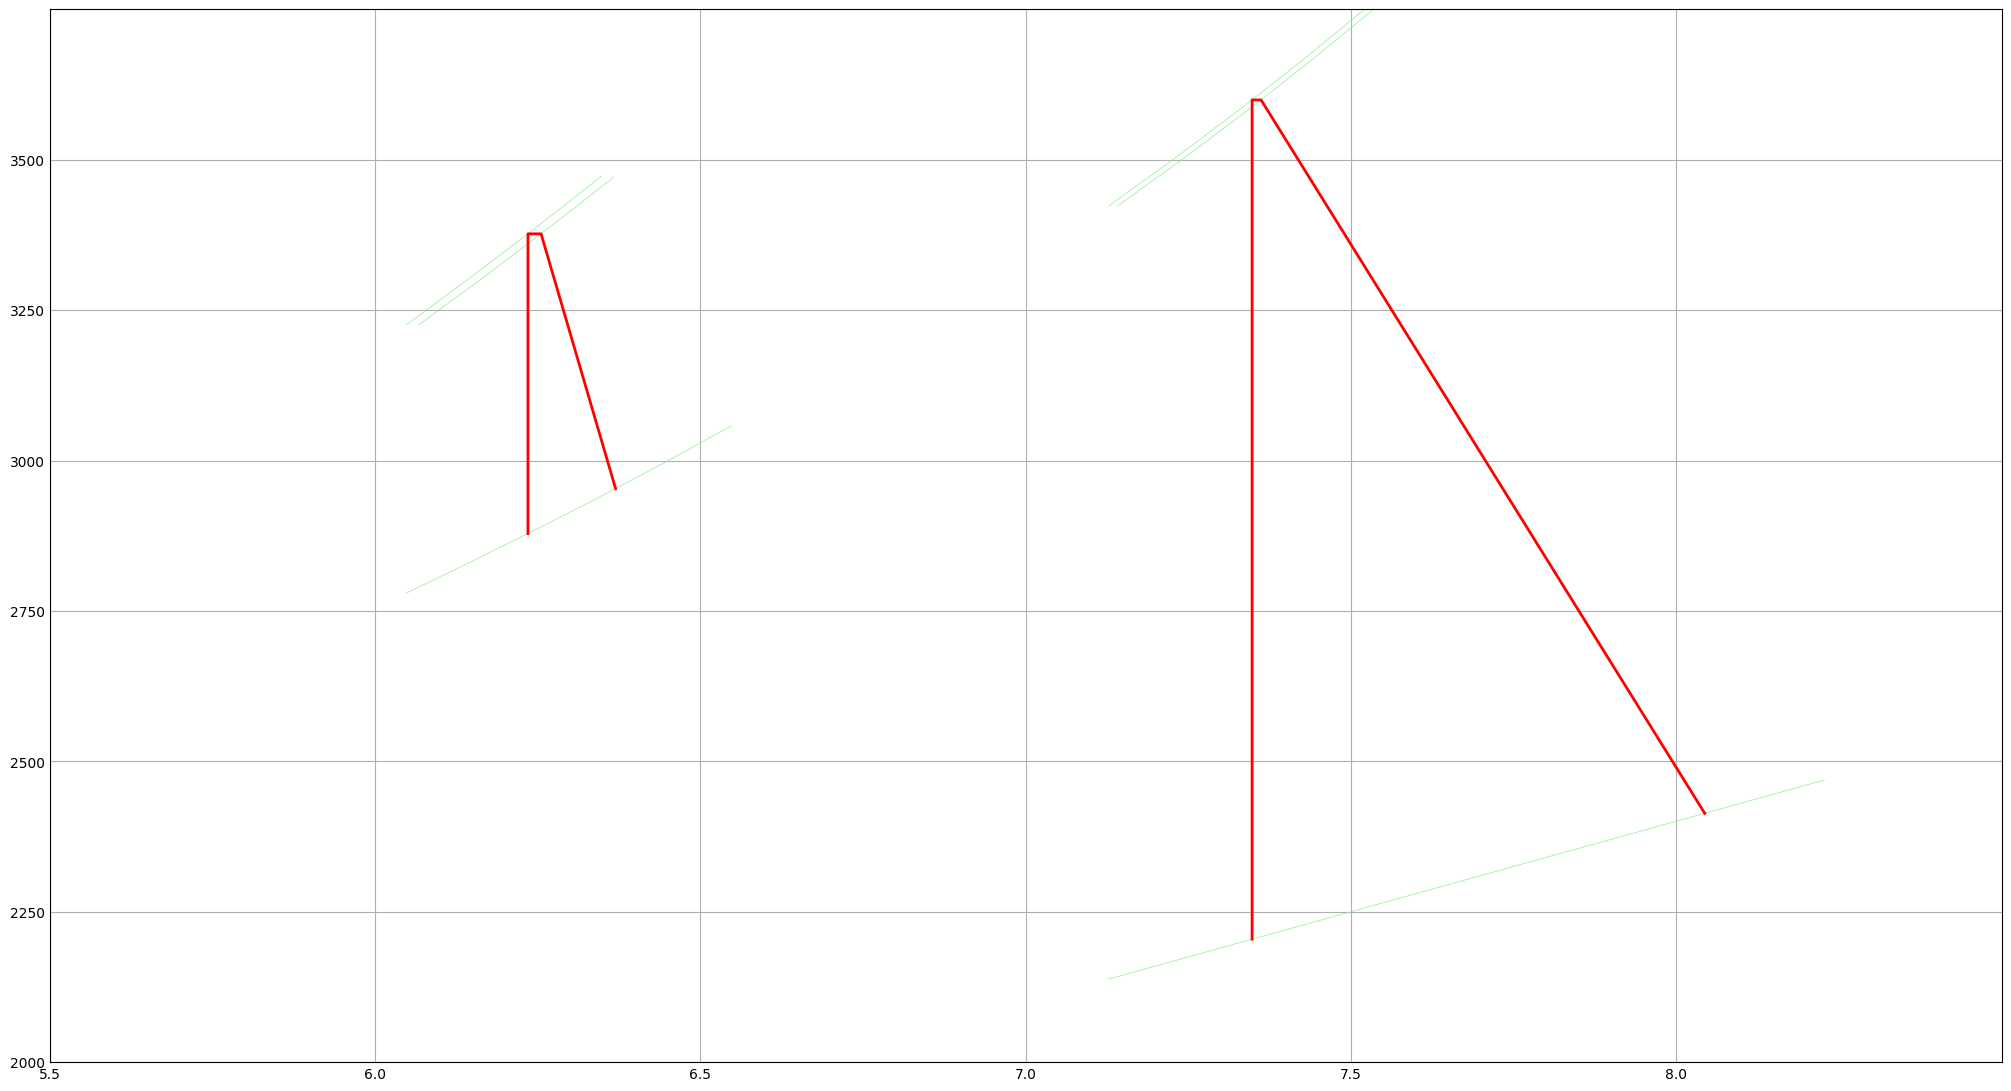

In [928]:
plt.style.use('_mpl-gallery')


fig, ax = plt.subplots(figsize=(20, 10.8), layout='constrained')

for i in list(pressure_lines_s.keys()):
    ax.plot(pressure_lines_s[i], pressure_lines_h[i], linewidth=0.5, color = "lightgreen")

ax.plot(s_1st, h_1st, linewidth=2.0, color = "red")
ax.plot(s_2nd, h_2nd, linewidth=2.0, color = "red")

# make data

# plot
ax.set(xlim=(6, 8.5), xticks=numpy.arange(5.5, 8.5, 0.5),
       ylim=(2000, 3750), yticks=numpy.arange(2000, 3750, 250))

plt.show()

In [929]:
'''stores properties of any array including boundary props.'''
class Array_Data:
        def __init__(self, speed_angle_e_bounds, speed_angle_bounds, t_bounds, M_bounds, b, W_min, mu_coeffs, speed_coeff_coeffs):
            self.speed_angle_e_bounds = speed_angle_e_bounds
            self.speed_angle_bounds = speed_angle_bounds 
            self.t_bounds = t_bounds
            self.M_bounds = M_bounds
            self.b = b
            self.W_min = W_min
            self.mu_coeffs = mu_coeffs
            self.speed_coeff_coeffs = speed_coeff_coeffs
        def get_mu(self, l):
            return self.mu_coeffs[0] + self.mu_coeffs[1] * self.b / l
        def get_speed_coeff_ver(self, l):
            return self.speed_coeff_coeffs[0] + self.speed_coeff_coeffs[1] * self.b / l
        def params_in_bounds(self, speed_angle_e, speed_angle, M):
            res = ''
            if speed_angle_e < min(self.speed_angle_e_bounds) or speed_angle_e > max(self.speed_angle_e_bounds):
                res = res + ' speed angle e '
                print(self.speed_angle_e_bounds, speed_angle_e)
            if speed_angle < min(self.speed_angle_bounds) or speed_angle > max(self.speed_angle_bounds):
                res = res + ' speed angle '
                print(self.speed_angle_bounds, speed_angle)
            if M < min(self.M_bounds) or M > max(self.M_bounds): 
                res = res + ' mach '
                print(self.M_bounds, M)
            return res
class vector2:
    def __init__(self, x0, y0, x1, y1):
        self.x0 = x0
        self.y0 = y0
        self.x1 = x1
        self.y1 = y1
    def __init__(self, x1, y1):
        self.x0 = 0
        self.y0 = 0
        self.x1 = x1
        self.y1 = y1

In [930]:
class Turbine_Stage:

    '''
    constants
    '''
    mu1_comma = 0.97
    alpha1_e = 15
    delta = 0.003
    xi_vs = 0
    
    mu_a = 0.5
    delta_a = 0.0025
    mu_r = 0.75
    z = 8
    k_friction = 0.7/1000
    m_ = 1
    k_v = 0.065
    i_ = 4
    sigma_twist_max = 20 * MPa
    sigma_stretch_max = 200 * MPa
    
    class Array:
        
        class Standart_Arrays(Enum):
            c_90_15_a = Array_Data([13, 17], [70, 120], [0.72, 0.87], [0, 0.85], 51.5 * mm, 0.45 * cm ** 3, [0.982, -0.005], [0.98, -0.008])
            r_30_21_a = Array_Data([19, 24], [25, 40], [0.58, 0.68], [0, 0.90], 25.6 * mm, 0.234 * cm ** 3, [0.965, -0.01], [0.96, -0.014])
        
        def __init__(self, profile_name, topt_choosen, e_opt, d, l, M):
            self.bounds = Turbine_Stage.Array.Standart_Arrays[profile_name].value
            self.l = l
            self.M = M
                
            self.z = math.pi * d * e_opt / self.bounds.b / topt_choosen
            if int(self.z) % 2 != 0:
                self.z = round(self.z) + round(self.z) % 2
            else:
                self.z = round(self.z) - round(self.z) % 2
                
            self.t = math.pi * d * e_opt / self.bounds.b / self.z
            self.mu = self.bounds.get_mu(l)
            
            self.placement_angle = 0
            self.ksi = 0
            self.speed_coeff = 0
            self.speed_angle = 0
            self.speed_angle_e = 0

            
        def set_specified_params(self, placement_angle, ksi, speed_angle_e, speed_angle_in):

            self.placement_angle = placement_angle
            self.speed_angle_e = speed_angle_e
            self.ksi = ksi
            
            self.speed_angle_in = speed_angle_in
            
            self.speed_coeff = math.sqrt(1 - self.ksi)
            self.speed_angle_out = math.degrees(math.asin(math.sin(math.radians(self.speed_angle_e)) * self.mu / self.speed_coeff))

        def check_for_errors(self):
            found = False
            if max([self.speed_coeff, self.bounds.get_speed_coeff_ver(self.l)]) / min([self.speed_coeff, self.bounds.get_speed_coeff_ver(self.l)]) - 1 > 0.01:
                print('Speed coefficient varies from verification result.')
                print(self.speed_coeff, self.bounds.get_speed_coeff_ver(self.l))
                found = True
            if not self.bounds.params_in_bounds(self.speed_angle_e, self.speed_angle_in, self.M) == '':
                print('Some params are out of bounds; namely' + self.bounds.params_in_bounds(self.speed_angle_e, self.speed_angle_in, self.M))
                found = True
            if not found:
                print('No mismatches found.')

        
    '''
    G - kg/s
    p0 - MPa
    t0 - C
    H0 - kJ/kg
    d - m
    n - s^-1
    '''
    def __init__(self, G, p0, t0, c0, H0, degree_of_reactivity, d, n, a0):
        self.G = G
        
        self.point_0 = gas(P=p0 * unit, T=to_kelvin(t0))
        self.u = math.pi * d * n
        
        self.c0 = c0
        self.H0 = H0
        self.degree_of_reactivity = degree_of_reactivity
        self.d = d
        self.n = n
        self.alpha0 = a0
        
        self.H0_c = (1 - self.degree_of_reactivity) * self.H0
        self.H0_r = self.degree_of_reactivity * self.H0
        
        self.point_1t = gas(h = self.point_0.h - self.H0_c, s = self.point_0.s)
        self.c1_t = math.sqrt(2 * self.H0_c * kJ)
        
        self.F1 = self.G * self.point_1t.v / self.mu1_comma / self.c1_t
        self.el1 = self.F1 / math.pi / self.d / math.sin(math.radians(self.alpha1_e))
        self.e_opt = 4 * math.sqrt(self.el1)
    
    '''setting nozzle array'''
    def set_nozzle_array(self, array_name, topt_choosen, l, M):
        self.nozzle_array = Turbine_Stage.Array(array_name, topt_choosen, self.e_opt, self.d, l, M)
    
    '''called after filling the nozzle array props according to array atlas'''
    def calc_point1(self):
        self.c1 = self.c1_t * self.nozzle_array.speed_coeff
        self.w1 = math.sqrt(self.c1 ** 2 + self.u ** 2 - 2 * self.c1 * self.u * math.cos(math.radians(self.nozzle_array.speed_angle_out)))
        self.betta1 = math.degrees(math.atan(math.sin(math.radians(self.nozzle_array.speed_angle_out)) / (math.cos(math.radians(self.nozzle_array.speed_angle_out)) - self.u / self.c1)))
        self.alpha1 = self.nozzle_array.speed_angle_out
        
        self.delta_H_c = self.c1_t ** 2 / 2 * (1 - self.nozzle_array.speed_coeff ** 2) / kJ
        self.point1 = gas(P = self.point_1t.P, h = self.point_1t.h + self.delta_H_c)
        self.w2t = math.sqrt(2 * self.H0_r * kJ + self.w1 ** 2)
        self.point_2t = gas(h = self.point1.h - self.H0_r, s = self.point1.s)
    
    '''swtting working array'''
    def set_working_array(self, array_name, topt_choosen, l, M):
        self.working_array = Turbine_Stage.Array(array_name, topt_choosen, self.e_opt, self.d, l, M)
        self.F2 = self.G * self.point_2t.v / self.working_array.mu / self.w2t
    
    '''called after the working array props according to array atlas'''
    def calc_point_2(self):
        self.w2 = self.w2t * self.working_array.speed_coeff
        self.c2 = math.sqrt(self.w2 ** 2 + self.u ** 2 - 2 * self.w2 * self.u * math.cos(math.radians(self.working_array.speed_angle_out)))
        self.alpha2 = math.degrees(math.atan(math.sin(math.radians(self.working_array.speed_angle_out)) / (math.cos(math.radians(self.working_array.speed_angle_out)) - self.u / self.w2)))
        self.betta2 = self.working_array.speed_angle_out
        self.delta_H_r = self.w2t ** 2 / 2 * (1 - self.working_array.speed_coeff ** 2) / kJ
    
    def calc_efficiency(self):
        
        self.delta_H_vs = self.c2 ** 2 / 2 / kJ
        self.E0 = self.H0 - self.xi_vs * self.delta_H_vs
        
        self.etta_ol = (self.E0 - self.delta_H_c - self.delta_H_r - (1 - self.xi_vs) * self.delta_H_vs) / self.E0
        self.etta_ol_ver = self.u * (self.c1 * math.cos(math.radians(self.alpha1)) + self.c2 * math.cos(math.radians(self.alpha2))) / self.E0 / kJ
        if math.fabs(self.etta_ol / self.etta_ol_ver - 1) > 0.01:
            print('Efficiencys are too different')
            print(self.etta_ol, self.etta_ol_ver)
        else:
            print('Efficiencys calculated correctly')
        
        self.cf = math.sqrt(2 * self.H0 * kJ)
        self.u_cf = self.u / self.cf
        self.u_cf_opt = self.nozzle_array.speed_coeff * math.cos(math.radians(self.alpha1)) / 2 / math.sqrt(1 - self.degree_of_reactivity)
        self.d_p = self.d + self.working_array.l
        self.delta_r = 0.001 * self.d_p
        self.delta_e = (1 / ((self.delta_a * self.mu_a) ** 2) + self.z / (self.delta_r * self.mu_r) ** 2) ** (-0.5)
        self.ksi_b_y = math.pi * self.d_p * self.delta_e * self.etta_ol / self.F1
        self.delta_H_y = self.ksi_b_y * self.E0
        self.ksi_d_tr = self.k_friction * self.d ** 2 / self.F1 * self.u_cf ** 3
        self.delta_H_tr = self.ksi_d_tr * self.E0
        self.ksi_v = self.k_v * (1 - self.e_opt) * self.u_cf ** 3 * self.m_ / self.e_opt / math.sin(math.radians(self.alpha1_e))
        self.B2 = self.working_array.bounds.b * math.sin(math.radians(self.working_array.placement_angle))
        self.ksi_segm = 0.25 * self.B2 * self.working_array.l / self.F1 * self.u_cf * self.etta_ol * self.i_
        self.ksi_partial = self.ksi_segm + self.ksi_v
        self.delta_H_partial = self.E0 * self.ksi_partial
        self.H_i = self.E0 - self.delta_H_c - self.delta_H_partial - self.delta_H_r - self.delta_H_tr - self.delta_H_vs * (1 - self.xi_vs) - self.delta_H_y
        self.etta_oi = self.H_i / self.E0
        self.N_i = self.G * self.H_i * kJ
        
    def calc_durability(self):
        self.sigma_twist = (self.G * self.H0 * self.etta_ol * self.working_array.l) / (2 * self.u * self.working_array.z * self.working_array.bounds.W_min * self.e_opt)
        self.b2_new = self.working_array.bounds.b * math.sqrt(self.sigma_twist / self.sigma_twist_max)
        self.bb = 2 * math.pi * self.n
        self.sigma_stretch = 0.5 * 7800 * self.bb ** 2 * self.d * self.working_array.l

In [931]:
G = inlet_mass_flow
d = 1.08
n = 60
P0 = p0
t0 = t0
c0 = 0
H0 = numpy.array([90,110])
p  = 0.1
a0 = 90

P0, t0, G

stages = [Turbine_Stage(G, p0, t0, c0, i, p, d, n, a0) for i in range(H0[0], H0[1]+1)]

#stage_variant.alpha1_e, stage_variant.alpha0

In [932]:
for stage_variant in stages:
    stage_variant.set_nozzle_array('c_90_15_a', 0.75, stage_variant.el1 / stage_variant.e_opt, stage_variant.c1_t / stage_variant.point_1t.w)

In [933]:
for stage_variant in stages:
    stage_variant.nozzle_array.set_specified_params(38, 0.065, stage_variant.alpha1_e, stage_variant.alpha0)
    stage_variant.nozzle_array.check_for_errors()

No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.


In [934]:
for stage_variant in stages:
    stage_variant.calc_point1()
#stage_variant.w1, stage_variant.c1, stage_variant.betta1, stage_variant.w2t

In [935]:
for stage_variant in stages:
    stage_variant.set_working_array('r_30_21_a', 0.6, stage_variant.nozzle_array.l + stage_variant.delta, stage_variant.w2t / stage_variant.point_2t.w)
#stage_variant.working_array.t, stage_variant.working_array.M

In [936]:
for stage_variant in stages:
    stage_variant.working_array.set_specified_params(81, 0.105, math.degrees(math.sin(stage_variant.F2 / stage_variant.e_opt / math.pi / stage_variant.d / stage_variant.working_array.l)), stage_variant.betta1)
    stage_variant.working_array.check_for_errors()

No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.
No mismatches found.


In [937]:
for stage_variant in stages:
    stage_variant.calc_point_2()
    stage_variant.calc_efficiency()
#stage_variant.N_i, stage_variant.etta_oi

Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly
Efficiencys calculated correctly


In [938]:
for stage_variant in stages:
    stage_variant.calc_durability()

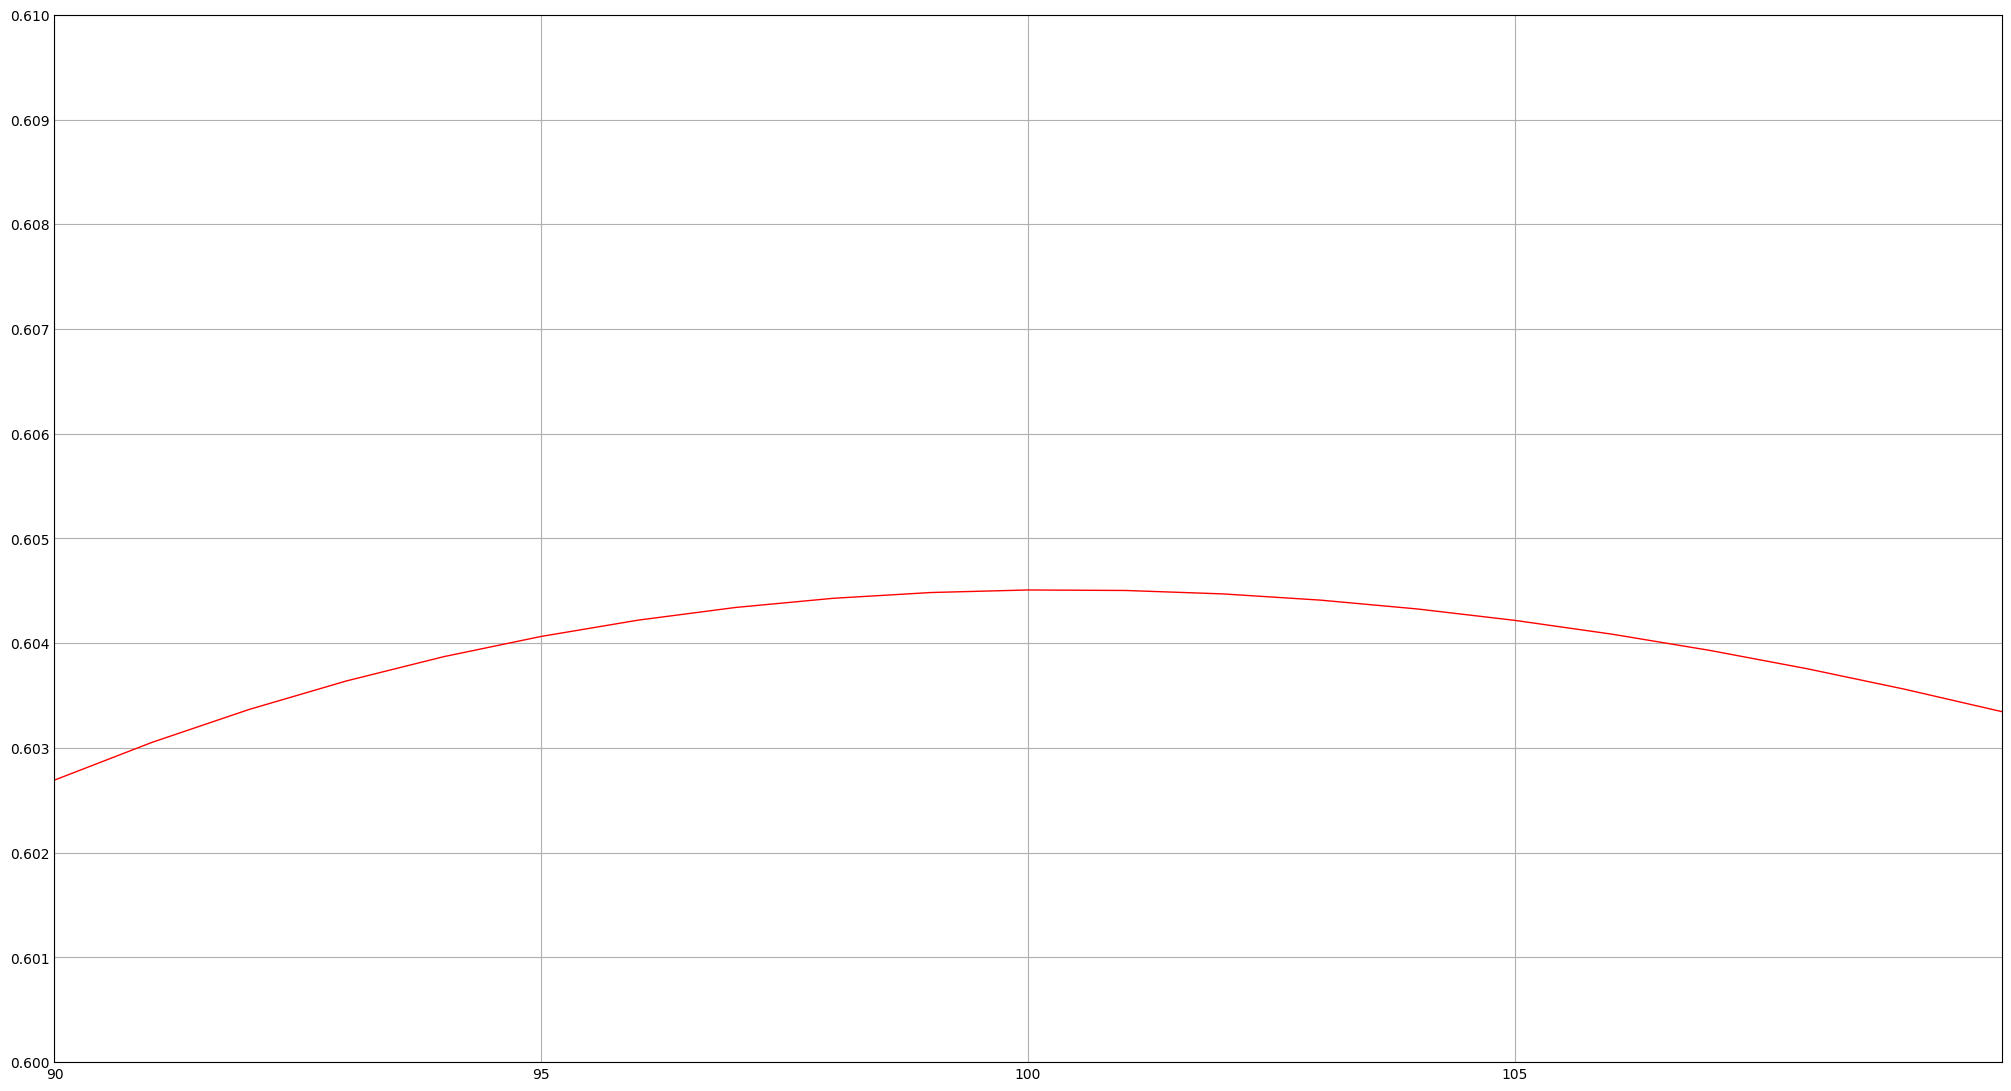

In [939]:
plt.style.use('_mpl-gallery')

fig, ax = plt.subplots(figsize=(20, 10.8), layout='constrained')

ax.plot([k.H0 for k in stages], [k.etta_oi for k in stages], linewidth=1, color = "red")

# make data

# plot
ax.set(xlim=(90, 110), xticks=numpy.arange(90, 110, 5),
       ylim=(0.6, 0.61), yticks=numpy.arange(0.6, 0.61, 0.001))

plt.show()

100 0.6045084225448689


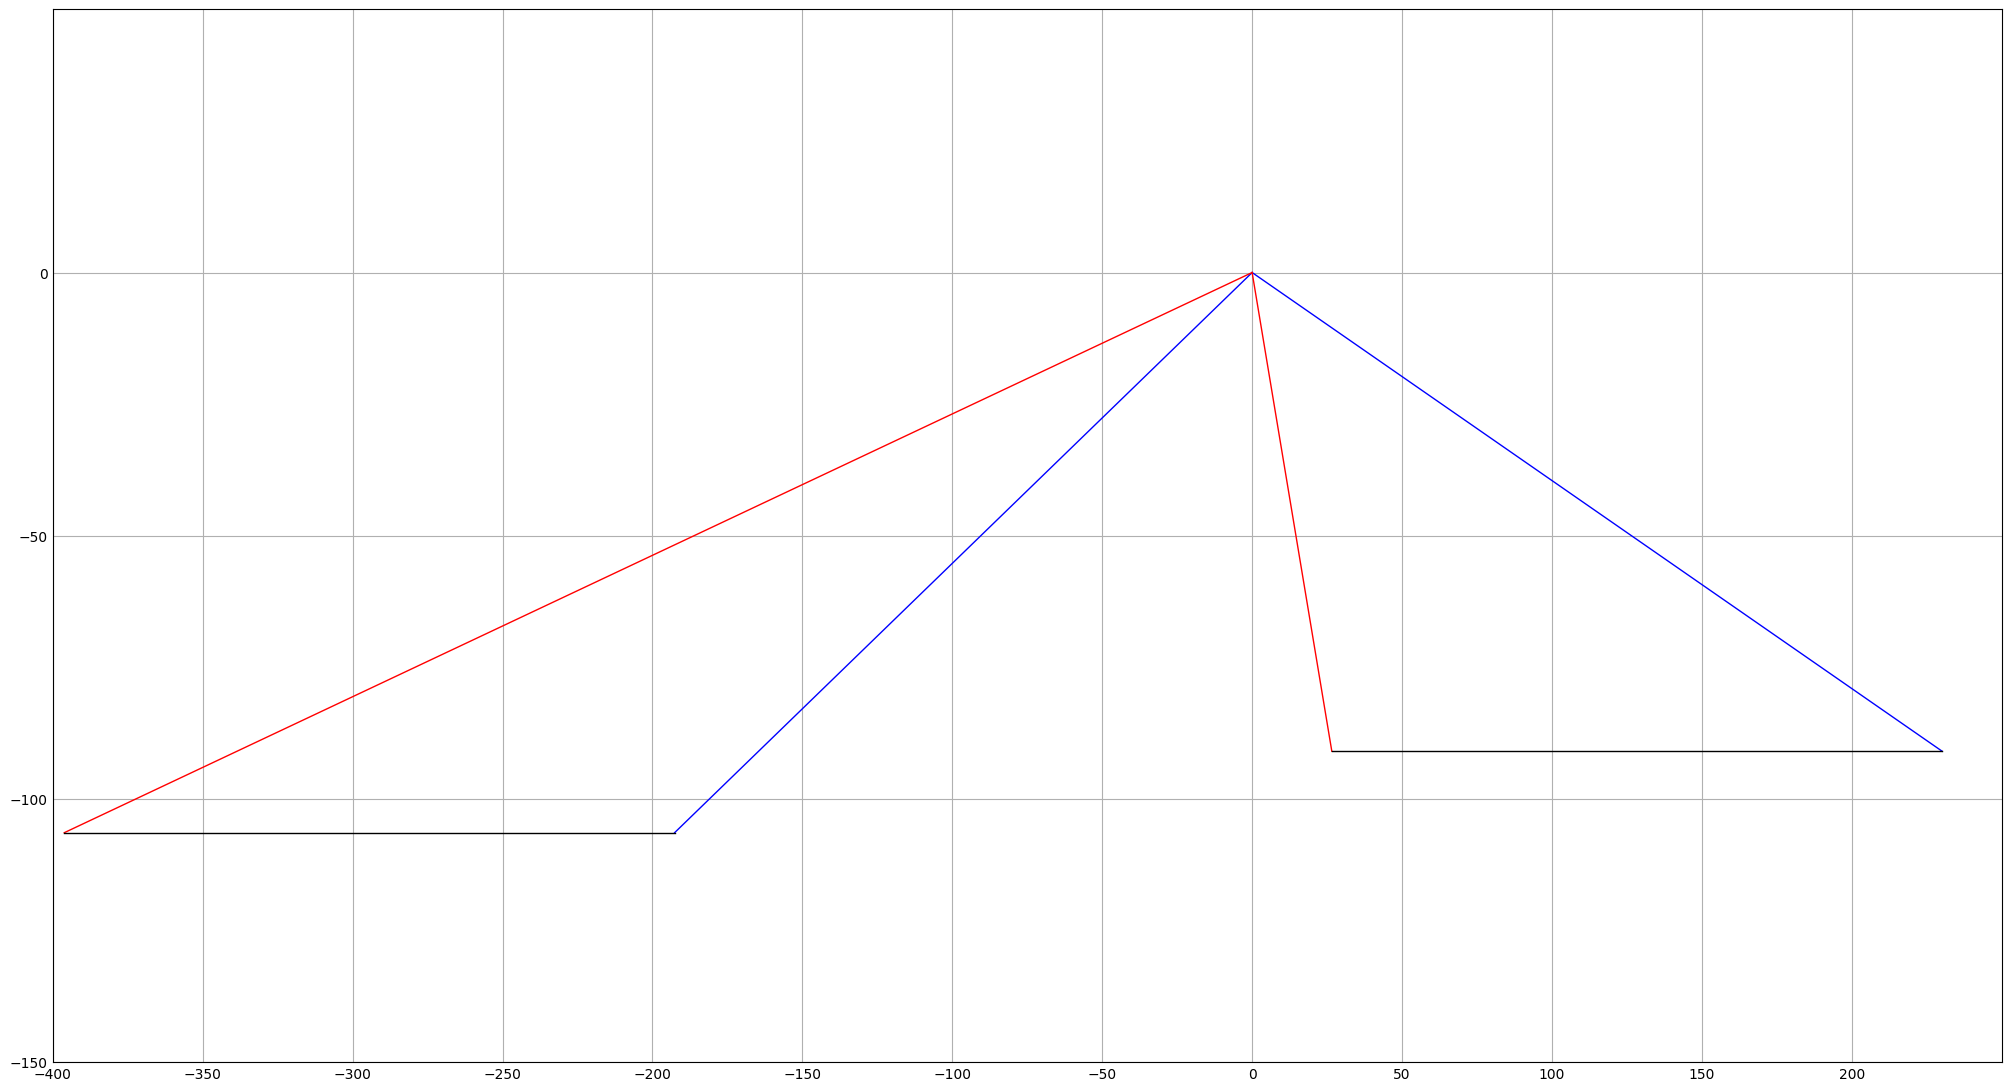

In [941]:
optimal_stage = max(stages, key = lambda x : x.etta_oi)
print(optimal_stage.H0, optimal_stage.etta_oi)

w1 = vector2(-optimal_stage.w1 * math.cos(math.radians(optimal_stage.betta1)), -optimal_stage.w1 * math.sin(math.radians(optimal_stage.betta1)))
c1 = vector2(-optimal_stage.c1 * math.cos(math.radians(optimal_stage.alpha1)), -optimal_stage.c1 * math.sin(math.radians(optimal_stage.alpha1)))    
w2 = vector2(optimal_stage.w2 * math.cos(math.radians(optimal_stage.betta2)), -optimal_stage.w2 * math.sin(math.radians(optimal_stage.betta2)))
c2 = vector2(optimal_stage.c2 * math.cos(math.radians(optimal_stage.alpha2)), -optimal_stage.c2 * math.sin(math.radians(optimal_stage.alpha2)))    

plt.style.use('_mpl-gallery')

fig, ax = plt.subplots(figsize=(20, 10.8), layout='constrained')

ax.plot([w1.x0, w1.x1], [w1.y0, w1.y1], linewidth=1, color = "blue")
ax.plot([w2.x0, w2.x1], [w2.y0, w2.y1], linewidth=1, color = "blue")
ax.plot([c1.x0, c1.x1], [c1.y0, c1.y1], linewidth=1, color = "red")
ax.plot([c2.x0, c2.x1], [c2.y0, c2.y1], linewidth=1, color = "red")

ax.plot([w1.x1, c1.x1], [w1.y1, c1.y1], linewidth=1, color = "black")
ax.plot([w2.x1, c2.x1], [w2.y1, c2.y1], linewidth=1, color = "black")


# make data

# plot
ax.set(xlim=(-400, 250), xticks=numpy.arange(-400, 250, 50),
       ylim=(-150, 50), yticks=numpy.arange(-150, 50, 50))

plt.show()